In [ ]:
import sys
sys.path.append('../')

# imports
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras as k
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from encoders.binding_2D_matrix_encoder import binding_encoding
# from miRBench.encoder import miRBindEncoder



# parameters
training_file_path = '../datasets/Balanced_dataset.tsv'

alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1., "AU": 1., "UA": 1.}
input_shape = (50, 20, 1)  # shape of the input image
learning_rate = 0.001  # learning rate
epochs = 20  # number of epochs/dataset iterations
batch_size = 32  # batch size

2024-11-25 20:45:04.547882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732563904.560904   95959 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732563904.564208   95959 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### ResBlock Class and Building ResNet function

In [2]:
# defining a custom Keras layer which inturn implements a residual block
@register_keras_serializable()
class ResBlock(layers.Layer):
    """
    Defines a Residual block based on the original ResNet paper.
    The block either maintains the input dimensions or downsamples based on the specified parameters.
    """

    def __init__(self, downsample=False, filters=16, kernel_size=3):
        """
        Initializes the residual block with optional downsampling.
        
        Parameters:
        - downsample: Boolean, whether to downsample the input (using stride of 2)
        - filters: Number of filters for the Conv2D layers
        - kernel_size: Size of the convolution kernel
        """
        # calling the parent class constructor
        super(ResBlock, self).__init__()

        # parameters for the residual block
        self.downsample = downsample
        self.filters = filters
        self.kernel_size = kernel_size

        # initialize first convolution layer, with stride 1 or 2 depending on downsampling
        self.conv1 = layers.Conv2D(kernel_size=self.kernel_size,
                                   strides=(1 if not self.downsample else 2),
                                   filters=self.filters,
                                   padding="same")
        self.activation1 = layers.ReLU()  # activation function after first convolution
        self.batch_norm1 = layers.BatchNormalization()  # batch normalization after first convolution
        
        # initialize second convolution layer with stride 1 (no downsampling here)
        self.conv2 = layers.Conv2D(kernel_size=self.kernel_size,
                                   strides=1,
                                   filters=self.filters,
                                   padding="same")

        # third convolution if downsampling is needed to match input dimensions
        if self.downsample:
          self.conv3 = layers.Conv2D(kernel_size=1,
                                     strides=2,
                                     filters=self.filters,
                                     padding="same")

        self.activation2 = layers.ReLU()  # activation after second convolution
        self.batch_norm2 = layers.BatchNormalization()  # batch normalization after second convolution

    def call(self, inputs):
        """
        Forward pass for the residual block. Applies the convolutions, activation, and adds the skip connection.

        Parameters:
        - inputs: Input tensor

        Returns:
        - Tensor after applying the residual block transformation
        """
        # first convolution, activation, and batch normalization
        x = self.conv1(inputs)
        x = self.activation1(x)
        x = self.batch_norm1(x)
        
        # second convolution (no downsampling here)
        x = self.conv2(x)

        # adjust input dimensions if downsampling
        if self.downsample:
            inputs = self.conv3(inputs)

        # add the input (skip connection) to the output of the convolutions
        x = layers.Add()([inputs, x])

        # final activation and batch normalization
        x = self.activation2(x)
        x = self.batch_norm2(x)

        return x

    def get_config(self):
        """
        Returns the configuration of the residual block (required for saving and loading the model).
        """
        return {'filters': self.filters, 'downsample': self.downsample, 'kernel_size': self.kernel_size}
    
# define the ResNet model
def build_resnet(input_shape):
    """
    Builds a simple ResNet model using custom residual blocks.
    """
    inputs = layers.Input(shape=input_shape)

    # initial Conv Layer
    x = layers.Conv2D(64, kernel_size=(3, 3), padding='same')(inputs)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)

    # add ResBlocks
    x = ResBlock(filters=64, downsample=False)(x)
    x = ResBlock(filters=64, downsample=False)(x)

    # flatten and add dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # binary classification (0 or 1)

    # build model
    model = models.Model(inputs, x)
    # compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy',metrics=['accuracy'])
    # output model summary
    model.summary()
    
    return model

#### Data Encoding and Building Model

In [4]:
# encode the data using your binding_2D_matrix_encoder's binding_encoding function
def encode_dataset(data, rna_type):
    # use the function from the binding_2D_matrix_encoder module
    return binding_encoding(data, rna_type, alphabet=alphabet)

# load the training dataset
print("----- <Loading Training Dataset> -----")
df_train = pd.read_csv(training_file_path, sep='\t')
print("----- <Dataset Loaded Successfully> -----\n")

# print the dataset shape and first few rows
print(f"Training Dataset shape: {df_train.shape}")
print(f"First few rows of the dataset:\n{df_train.head()}\n")

# Split df_train into actual training and validation sets
training_data, validation_data = train_test_split(df_train, test_size=0.1, random_state=42)
print(f"Size of training set: {len(training_data)}")
print(f"Size of validation set: {len(validation_data)}\n")

print("----- <Encoding Data> -----")
encoded_training_data, training_labels = encode_dataset(training_data, "noncodingRNA")
print("----- <Training Data Encoded Successfully> -----")
encoded_validation_data, validation_labels = encode_dataset(validation_data, "noncodingRNA")
print("----- <Validation Data Encoded Successfully> -----")
print("----- <Successfully Encoded Data> -----\n")
'''Displaying the encoded data'''
# print(f"Encoded training data shape: {encoded_training_data.shape}")
# print(f"Encoded validation data shape: {encoded_validation_data.shape}\n")
# print(f"Encoded testing data shape: {encoded_testing_data.shape}")
# print(f"First encoded training example:\n{encoded_training_data[0]}")
# print(f"First training label: {training_labels[0]}\n")
# print(f"First encoded testing example:\n{encoded_testing_data[0]}")

# build the ResNet model
input_shape = encoded_training_data.shape[1:]  # assuming the encoded data is 4D (samples, height, width, channels)
print("----- <Building Model> -----")
model = build_resnet(input_shape)
print("----- <Model Built Successfully> -----\n")

----- <Loading Training Dataset> -----
----- <Dataset Loaded Successfully> -----

Training Dataset shape: (20000, 11)
First few rows of the dataset:
                                                gene  \
0  CAATTCTGCAAATGAATTATATAAAATGGTCATATTGAGGGACTAC...   
1  CATCGTCAAGCATGCCTTCGAGGTCATACACCTGCTCACAGGCGAG...   
2  GAATTAAGGATCGATGCACTGGGGTTTTAAGGAGCCCTCTGGTCCC...   
3  ACATCATTTCTACTACAGTGGCGGAGCCGTACAGGACCTGTTTCAC...   
4  TTTGAATGGCCATGGCTAAGCAATTCTCACTTGGTGCTGATTGGTT...   

               noncodingRNA noncodingRNA_fam         feature  label chr  \
0    CTAGGTATGGTCCCAGGGATCC          mir-331          intron      0  15   
1  TCTGCAGGTCCTGGTGAACGCCAT     miR-10394-5p  five_prime_utr      1   6   
2    TCAGTGCATCACAGAACTTTGT          mir-148          intron      1  20   
3    ACTGCTGAGCTAGCACTTCCCG           mir-17  five_prime_utr      1   6   
4    TCCGAGCCTGGGTCTCCCTCTT          mir-615     exon,intron      0  17   

         start        end strand  \
0   56982954.0   56983003  

I0000 00:00:1732563943.382942   95959 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 20, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 20, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 50, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResBlock)            │ (None, 50, 20, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_1 (ResBlock)          │ (None, 50, 20, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,768,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,918,657 (125.57 MB)

 Trainable params: 32,918,017 (125.57 MB)

 Non-trainable params: 640 (2.50 KB)

----- <Model Built Successfully> -----



#### Training Model

In [5]:
# train the model
print("----- <Training Model> -----")
history = model.fit(encoded_training_data, training_labels, epochs=epochs, batch_size=batch_size, 
                    validation_data=(encoded_validation_data, validation_labels))
print("----- <Model Trained Successfully> -----\n")

----- <Training Model> -----
Epoch 1/20


I0000 00:00:1732563990.152196   96228 service.cc:148] XLA service 0x7fd96c012d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732563990.152237   96228 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
I0000 00:00:1732563990.497822   96228 cuda_dnn.cc:529] Loaded cuDNN version 90501


  9/563 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4760 - loss: 4.0213

I0000 00:00:1732563992.346360   96228 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5900 - loss: 0.9413 - val_accuracy: 0.6680 - val_loss: 0.6094
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7657 - loss: 0.4782 - val_accuracy: 0.6780 - val_loss: 0.8336
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8535 - loss: 0.3292 - val_accuracy: 0.6960 - val_loss: 0.6358
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9297 - loss: 0.1606 - val_accuracy: 0.6735 - val_loss: 1.3358
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9707 - loss: 0.0781 - val_accuracy: 0.6855 - val_loss: 1.1366
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9795 - loss: 0.0539 - val_accuracy: 0.6940 - val_loss: 1.6252
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9841 - loss: 0.0432 - val_accuracy: 0.6985 - val_loss: 1.4806
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9866 - loss: 0.0371 - val_accuracy: 0.6

#### Plots and Evaluation

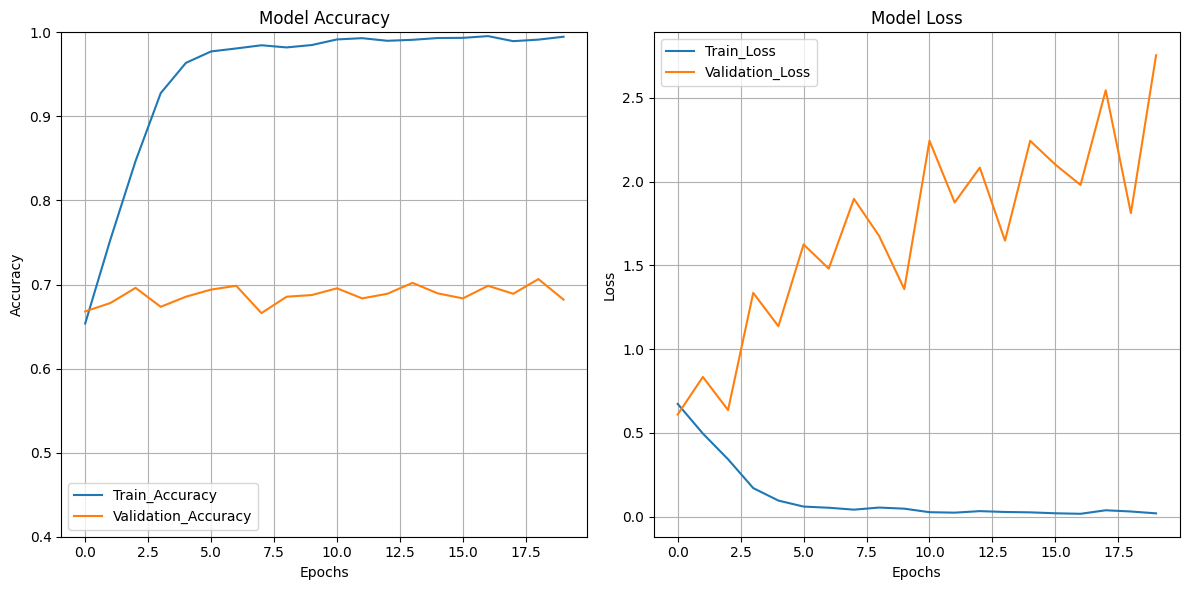

In [6]:
# plotting training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axis(ymin=0.4, ymax=1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train_Accuracy', 'Validation_Accuracy'])
plt.tight_layout()
plt.grid()

# plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train_Loss', 'Validation_Loss'])
plt.tight_layout()
plt.grid()

plt.show()

In [9]:
# evaluate the model

# parameters
testing_file_path = '../datasets/testing/test_set_1_100_CLASH2013_paper.tsv'

# load the testing dataset
print("----- <Loading Testing Dataset> -----")
df_test = pd.read_csv(testing_file_path, sep='\t')
print("----- <Dataset Loaded Successfully> -----\n")

# print the dataset shape and first few rows
print(f"Testing Dataset shape: {df_test.shape}")
print(f"First few rows of the dataset:\n{df_test.head()}\n")

# encode the testing data
print("----- <Encoding Data> -----")
encoded_testing_data, testing_labels = encode_dataset(df_test, "miRNA")         # encode_dataset(df_test, "noncodingRNA")
print("----- <Testing Data Encoded Successfully> -----")
print("----- <Successfully Encoded Data> -----\n")


print("----- <Evaluating Model> -----")
test_loss, test_accuracy = model.evaluate(encoded_testing_data, testing_labels)

# get predictions
predictions = model.predict(encoded_testing_data)
roc_auc = roc_auc_score(testing_labels, predictions)
print("----- <Model Evaluated Successfully> -----\n")

# display results
print(f"Test loss: {round(test_loss, 4)}\nTest accuracy: {round(test_accuracy, 4)} - {round(test_accuracy, 4) * 100}%")
print(f"Area Under Curve: {round(roc_auc, 4)}")


----- <Loading Testing Dataset> -----
----- <Dataset Loaded Successfully> -----

Testing Dataset shape: (202000, 3)
First few rows of the dataset:
                  miRNA                                               gene  \
0  TGAGGTAGTAGGTTGTATAG  ATGTCAACCTACCTACTTCTAAGCACAGGGTATGAAGCTCTCTTTC...   
1  CAAAGTGCTTACAGTGCAGG  CTTTCCTGCACTGTAAGATCCTGGCAACATCTGCCCTGAACTTCAG...   
2  TGTCTGCCCGCATGCCTGCC  AGCAGGTTTGTTGGCAGATGCTCGTTCTTTAGCAGACATAGCAAGA...   
3  TATTGCACTTGTCCCGGCCT  ACGTGCAATAGGGTGGAAACCAAACTGCTCCATGCCGGGTTATTTA...   
4  CAAAGTGCTGTTCGTGCAGG  CCTGCAGATTGATCTTGTGCTGCAATTCTACATCTAAAGTGATCCC...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

----- <Encoding Data> -----
----- <Testing Data Encoded Successfully> -----
----- <Successfully Encoded Data> -----

----- <Evaluating Model> -----
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6139 - loss: 4.1459
6313/6313 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
----- <Model Evaluated Successfully> -----

Tes

#### Saving Model

In [ ]:
# save the model
print("----- <Saving Model> -----")
model.save("miRBind_ResNet.keras")
print("----- <Model Saved Successfully> -----\n")